In [1]:
pip install -U imbalanced-learn

You should consider upgrading via the 'C:\Users\user\anaconda3\python.exe -m pip install --upgrade pip' command.


In [10]:
import sys
import time
from collections import Counter

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import shap
import sklearn.neighbors._base
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (make_scorer, roc_auc_score,
                             roc_curve, confusion_matrix)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     StratifiedKFold, train_test_split, cross_val_predict)
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_pickle(r"C:\Users\user\Downloads\P7.pkl")
df.shape

(49920, 11)

### SMOTE

In [3]:
X = df.iloc[:,0:9]
y = df.iloc[:,10]

In [4]:
counter = Counter(y)
print(counter)

Counter({0.0: 45341, 1.0: 4579})


In [5]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [6]:
counter = Counter(y)
print(counter)

Counter({0.0: 45341, 1.0: 45341})


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

#Logistic Regression

In [8]:
lr = LogisticRegression()
lr.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [9]:
parameters = {'penalty':['l1', 'l2', 'elasticnet', 'none'], 
              'dual': [True, False], 'tol': [0.0001,0.00001, 0.001], 
              'max_iter':[20,40,60]}

In [11]:
def costs(y_test, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    tp_value = 0
    tn_value = 1
    fp_value = 0
    fn_value = -10
    
    gain = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    gain_max = (fp+tn)*tn_value + (fn+tp)*tp_value
    gain_min = (fp+tn)*fp_value + (fn+tp)*fn_value
    gain_norm = (gain - gain_min)/(gain_max - gain_min)
    
    return gain_norm

myscorer = make_scorer(costs)

In [12]:
lr = GridSearchCV(estimator=lr, param_grid=parameters, cv=5, scoring=myscorer)
lr.fit(X_train, y_train)
print(lr.best_params_)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

{'dual': False, 'max_iter': 40, 'penalty': 'l2', 'tol': 0.0001}


In [24]:
reg = LogisticRegression(dual=False, max_iter=40, penalty="l2", tol=0.0001).fit(X_train, y_train)
y_pre=reg.predict(X_test)

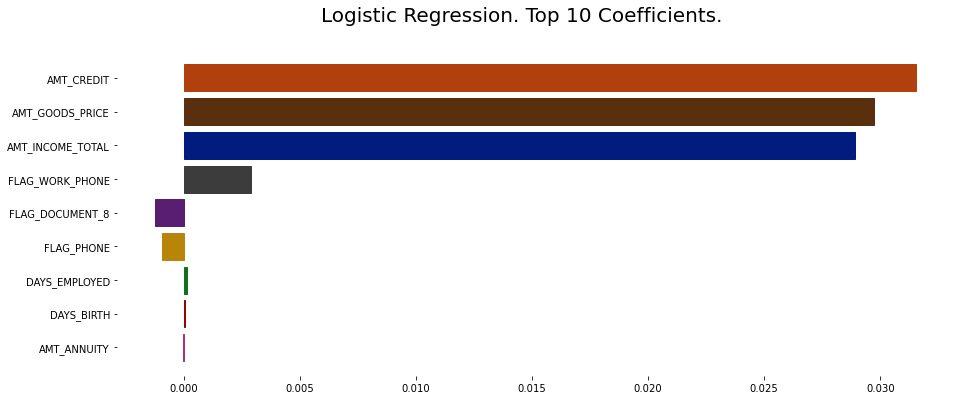

In [26]:
plt.figure(figsize=(15,6))
color_list =  sns.color_palette("dark", len(df.columns)-1) 
top_x = 10
logistic_reg_coeff = reg.coef_[0]
idx = np.argsort(np.abs(logistic_reg_coeff))[::-1] 
lreg_ax = plt.barh(
    df.columns[idx[:top_x]][::-1], logistic_reg_coeff[idx[:top_x]][::-1])
for i,bar in enumerate(lreg_ax):
  bar.set_color(color_list[idx[:top_x][::-1][i]])
  plt.box(False) 
lr_title = plt.suptitle("Logistic Regression. Top " + str(top_x) + " Coefficients.", 
                        fontsize=20, fontweight="normal")

In [27]:
cdf = pd.DataFrame({"Variables":df.iloc[:,0:9].columns, 
                    "Coefficients":reg.coef_.T.flatten()})
cdf.sort_values(ascending=False, by="Coefficients")

,Variables,Coefficients
1,AMT_CREDIT,0.031534
5,AMT_GOODS_PRICE,0.029708
0,AMT_INCOME_TOTAL,0.028917
7,FLAG_WORK_PHONE,0.002888
2,DAYS_EMPLOYED,0.000126
3,DAYS_BIRTH,0.000038
6,AMT_ANNUITY,-0.000011
8,FLAG_PHONE,-0.000931
4,FLAG_DOCUMENT_8,-0.001235


In [28]:
list(cdf.sort_values(ascending=False, by="Coefficients")["Variables"])

['AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'FLAG_WORK_PHONE',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'FLAG_PHONE',
 'FLAG_DOCUMENT_8']

In [29]:
ROC_reg_test = roc_auc_score(y_test,reg.predict(X_test))

In [30]:
ROC_reg_ent = roc_auc_score(y_train, reg.predict(X_train).reshape(-1, 1))

In [50]:
ROC_reg_ent

0.5712115104128596

# Random Forest for classification

In [15]:
rf = RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [16]:
parameters = [{
'max_depth':[10,15,20],
 'min_samples_leaf': [10,20,30],
 'max_features': [2,4,6,8,10],
}]

In [17]:
rf2 = GridSearchCV(rf, parameters, cv=5, scoring=myscorer)
rf2.fit(X_train, y_train)
print(rf2.best_params_)


45 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\envs\dash_\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\envs\dash_\lib\site-packages\sklearn\ensemble\_forest.py", line 442, in fit
    trees = Parallel(
  File "C:\Users\user\anaconda3\envs\dash_\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\envs\dash_\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dis

{'max_depth': 20, 'max_features': 8, 'min_samples_leaf': 10}


In [32]:
rf = RandomForestClassifier(max_depth=20, min_samples_leaf=10, max_features=8)
rf = rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [33]:
ROC_rf_test = roc_auc_score(y_test,rf.predict(X_test))

In [34]:
ROC_rf_ent = roc_auc_score(y_train, rf.predict(X_train).reshape(-1, 1))

In [35]:
ROC_rf_test

0.9051909986053905

In [36]:
ROC_rf_ent

0.9256190126904789

# GradientBoosting

In [18]:
gb = GradientBoostingClassifier()

In [19]:
parameters = [{'n_estimators':[80,100,120],
 'max_depth': [1,2,3],
 'learning_rate': [0.01,0.1,0.2],
}]

In [20]:
gb = GridSearchCV(estimator=gb, param_grid=parameters, cv=5, scoring=myscorer)
gb.fit(X_train, y_train)
print(gb.best_params_)

{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 80}


In [37]:
gb = GradientBoostingClassifier(
    n_estimators=80, max_depth=1, learning_rate=0.01)
gb = gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

In [38]:
ROC_gb_test = roc_auc_score(y_test,gb.predict(X_test))

In [39]:
ROC_gb_ent = roc_auc_score(y_train, gb.predict(X_train).reshape(-1, 1))

In [40]:
ROC_gb_test

0.6028937967214707

# Lightgmb

In [21]:
clf = lgb.LGBMClassifier()
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [22]:
parameters = [{'n_estimators':[80,100,120],
 'max_depth': [1,2,3],
 'learning_rate': [0.01,0.1,0.2],
}]

In [23]:
clf = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, scoring=myscorer)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 80}


In [41]:
clf = lgb.LGBMClassifier(n_estimators=80, max_depth=1, learning_rate=0.01)
clf = clf.fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)

In [42]:
ROC_clf_test = roc_auc_score(y_test,clf.predict(X_test))

In [43]:
ROC_clf_ent = roc_auc_score(y_train, clf.predict(X_train).reshape(-1, 1))

In [44]:
ROC_clf_test

0.6028937967214707

# Comparaison

In [45]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, y_pre)
fpr2, tpr2, thresh2 = roc_curve(y_test, y_pred_rf)
fpr3, tpr3, thresh3 = roc_curve(y_test, y_pred_gb)
fpr4, tpr4, thresh4 = roc_curve(y_test, y_pred_clf)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

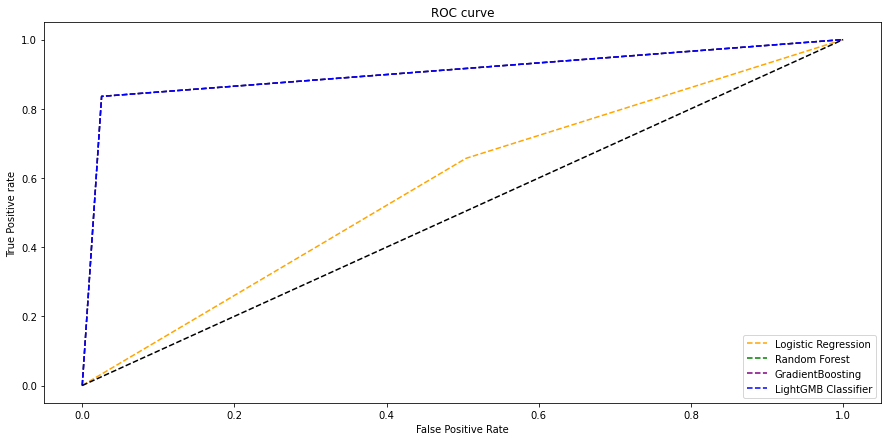

In [46]:
plt.figure(figsize=(15,7))
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Random Forest')
plt.plot(fpr2, tpr2, linestyle='--',color='purple', label='GradientBoosting')
plt.plot(fpr2, tpr2, linestyle='--',color='blue', label='LightGMB Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

RF, LightGMB et Gradient Boosting ont la même courbe ROC

In [47]:
df_perf = pd.DataFrame(
    {"Modèle":["Light GMB Classifier",  
                "Gradient Boosting Classifier", 
                "Random Forest"], 
                "ROC_AUC_entraînement":[ROC_clf_ent, ROC_gb_ent, ROC_rf_ent], 
                "ROC_AUC_test":[ROC_clf_test, ROC_gb_test, ROC_rf_test]})

In [48]:
fig = go.Figure(data=[
    go.Bar(name='Test', x=df_perf["Modèle"], y=df_perf["ROC_AUC_entraînement"]),
    go.Bar(name='Entraînement', x=df_perf["Modèle"], y=df_perf["ROC_AUC_test"])
])
fig.update_yaxes(range=[0,1])

fig.update_layout(barmode='group', title="Score ROC suivant les modèles")
fig.show()

In [49]:
df_perf

,Modèle,ROC_AUC_entraînement,ROC_AUC_test
0,Light GMB Classifier,0.601686,0.602894
1,Gradient Boosting Classifier,0.601686,0.602894
2,Random Forest,0.925619,0.905191


# Shap (TreeExplainer)

In [ ]:
N = 500
random_samp = df.sample(N).index
features_sel = df.iloc[:,0:9].loc[random_samp]
target_sel = df.iloc[:,10].loc[random_samp]

In [ ]:
customer_idx = features_sel.sample(1).index.values[0]

features_cust = features_sel.loc[customer_idx: customer_idx]
target_cust = df.iloc[:,10].loc[customer_idx: customer_idx]

print('shape of dataframes: ',
      features_cust.shape,
      features_sel.shape)

shape of dataframes:  (1, 9) (500, 9)


In [ ]:
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(features_sel)

nearest_cust_idx = neigh.kneighbors(X=features_cust,
                       n_neighbors=20,
                       return_distance=False).ravel()

features_neigh = features_sel.iloc[nearest_cust_idx]
target_neigh = df.iloc[:,10].iloc[nearest_cust_idx]

features_neigh_ = pd.concat([features_neigh, features_cust], axis=0)
target_neigh_ = df.iloc[:,10].loc[features_neigh_.index]

In [ ]:
explainer = shap.TreeExplainer(rf)

In [ ]:
shap_values = explainer.shap_values(features_neigh_) 

In [ ]:
expected_value = explainer.expected_value[1]

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(features_sel)[1]

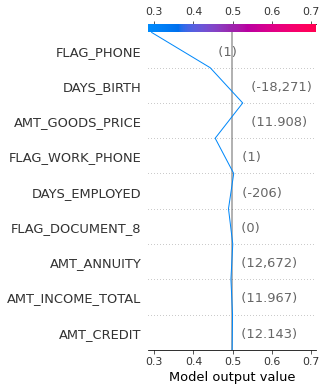

In [ ]:
# decision plot of the customer
shap.decision_plot(expected_value,
                   explainer.shap_values(features_cust)[1],
                   features_cust, # ne change rien ?
#                    highlight=0,
                   show=False)
plt.gcf().set_size_inches(3,6)
plt.show()

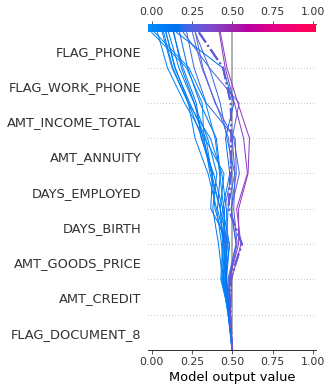

In [ ]:
# decision plot of neighbors with customer highlighted

highlight_mask = [False if idx != customer_idx else True for idx in features_neigh_.index]

shap.decision_plot(expected_value,
                   explainer.shap_values(features_neigh_)[1], # shap values
                   features_neigh_, # features (X)
                   highlight=highlight_mask,
                   show=False)
plt.gcf().set_size_inches(3,6)
plt.show()

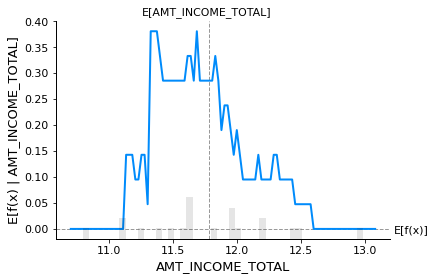

In [ ]:
# partial dependance of one variable for the n nearest neighbors + customer
shap.plots.partial_dependence("AMT_INCOME_TOTAL",
                              rf.predict,
                              features_neigh_,
                              ice=False,
                              model_expected_value=True,
                              feature_expected_value=True)

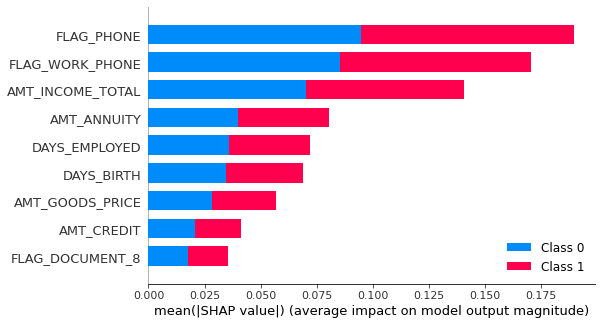

<Figure size 432x288 with 0 Axes>

In [ ]:
shap.summary_plot(shap_values, features_cust, plot_type="bar")
plt.savefig("shap.eps", format='eps', dpi=1000, bbox_inches='tight')

In [ ]:
# Beeswarm plot for 20 neighbors and the customer
shap.summary_plot(shap_values[1], # shap values
                  features_neigh_.values, # data (np.array)
                  feature_names=features_neigh_.columns)
plt.gcf().set_size_inches((14,3))

plt.show()

# Shap (Kernel Explainer)

In [ ]:
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(X_train)
sub_sampled_train_data = shap.sample(scaled_train_data, 500, random_state=0)
scaled_test_data = scaler.transform(X_test) 
subsampled_test_data = shap.sample(scaled_test_data, 500, random_state=0)

In [ ]:
start_time = time.time()
explainer = shap.KernelExplainer(rf.predict_proba, sub_sampled_train_data)
shap_values = explainer.shap_values(subsampled_test_data,  l1_reg="aic")
elapsed_time = time.time() - start_time

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/500 [00:00<?, ?it/s]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
The default of 'no

In [ ]:
print("Kernel Explainer SHAP run time", round(elapsed_time,3) , " seconds. ")
print("SHAP expected value", explainer.expected_value)
print("Model mean value", clf.predict_proba(scaled_train_data).mean(axis=0))
print("Model prediction for test data", clf.predict_proba(subsampled_test_data))
shap.initjs()
pred_ind = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][0], 
                subsampled_test_data[0], feature_names=features_sel.columns)

In [ ]:
# shap.initjs()
# shap.summary_plot(shap_values, subsampled_test_data, 
#                   feature_names=features_sel.columns, max_display=10)